In [2]:
import os
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from IPython.display import Image

cwd = os.getcwd()
path_data = os.path.join(cwd, "shots_data.csv")
path_image = Image(filename='court_diagram.jpeg') 

df = pd.read_csv(path_data)
pandas_profiling.ProfileReport(df,infer_dtypes=False)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the above profile of the data we can tell there are 280 shots for each team, Team A and Team B. The data has no missing values present and we get a plot of all of the shot coordinates matching the half-court image below. We can tell from the x and y distributions that more frequently shots were taken from the middle of the court and close to the hoop. Now we can proceed to create the three zones described in the assignment.

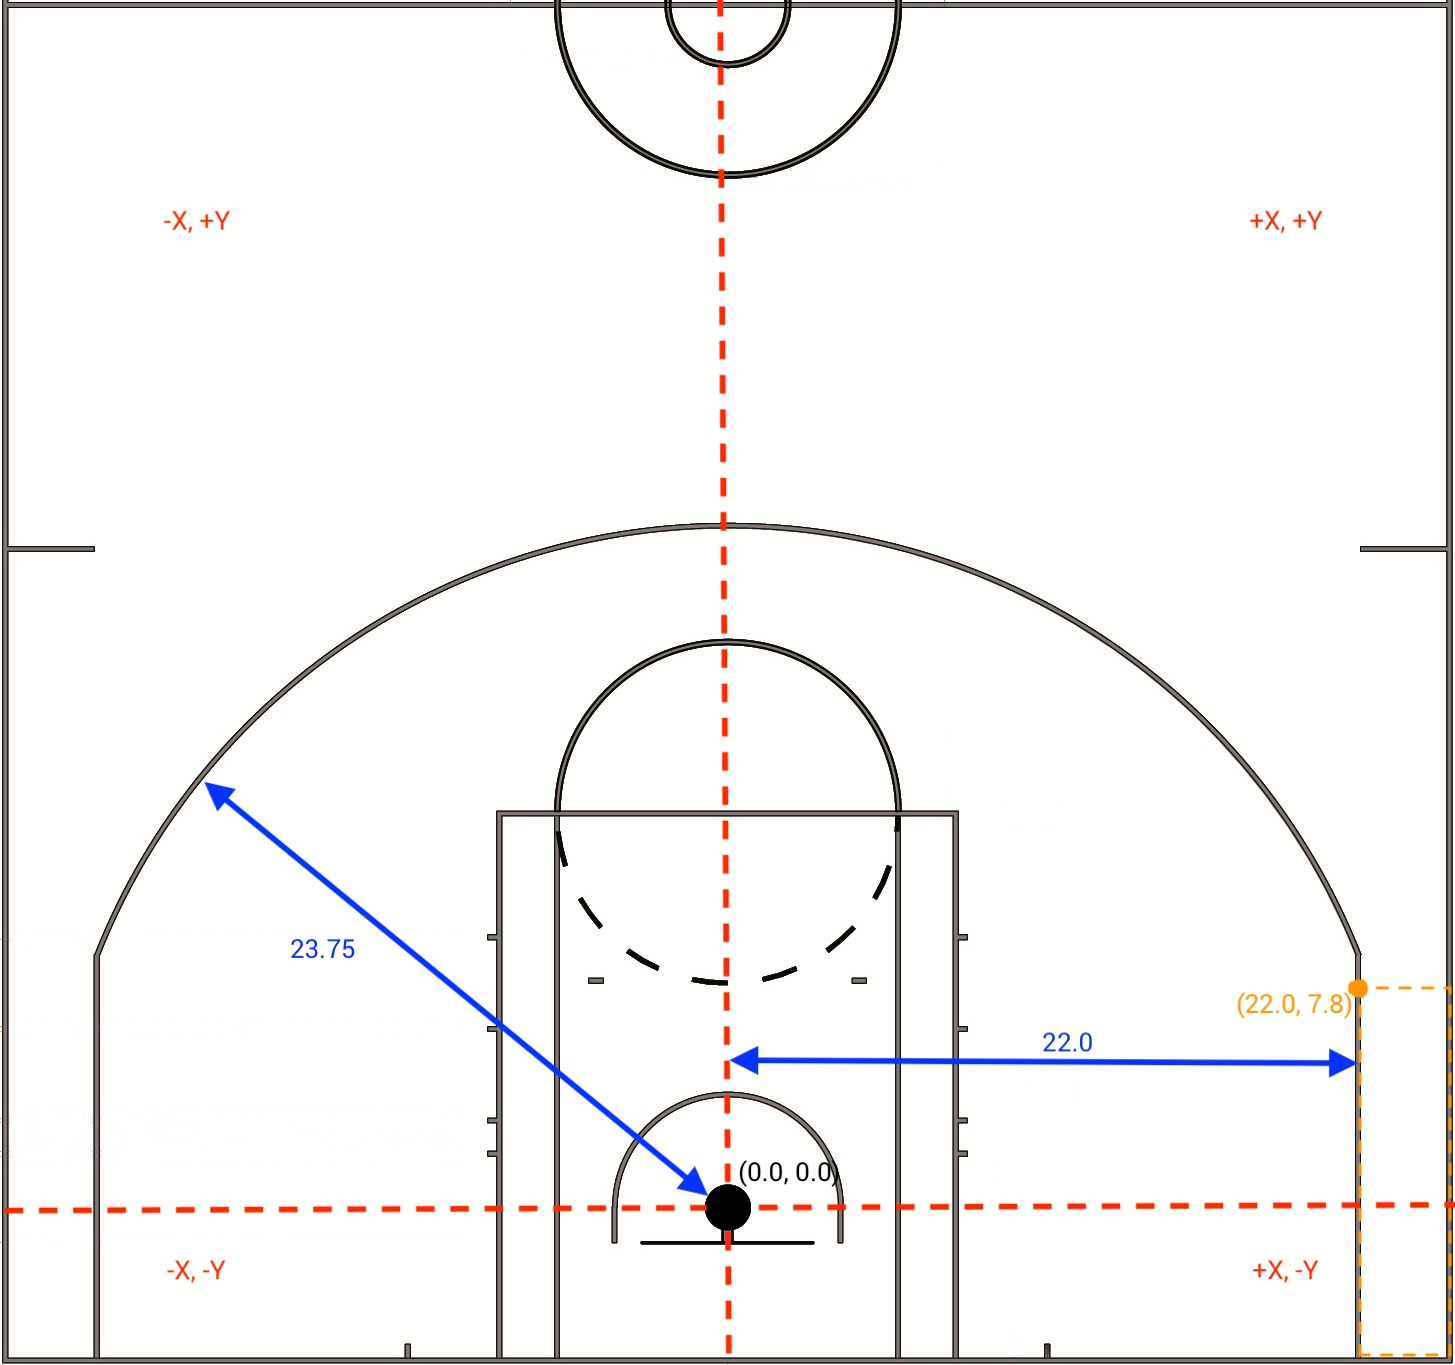

In [3]:
path_image

In [4]:
# Add distance between hoop as dist and distance between y-axis as ydist
p1 = df[["x","y"]]
p2 = pd.DataFrame(np.zeros(shape=(len(p1),len(p1.columns))), columns = ['x','y'])
df['dist'] = ((p1 - p2)**2).sum(axis=1) ** 0.5 

df['zone'] = '2PT'  # set the default zone to be 2PT

mask_nc3 = (df['dist'] > 23.75) & (df['y'] > 7.8)  # get non-corner 3s, if its on the line its a 2
df.loc[mask_nc3,'zone'] = 'NC3'

mask_c3 = (df['x'].abs() > 22) & (df['y'] <= 7.8)  # distance from y axis determines corner 3
df.loc[mask_c3,'zone'] = 'C3'

df

,team,x,y,fgmade,dist,zone
0,Team A,-23.1,3.5,0,23.363647,C3
1,Team A,0.0,25.1,1,25.100000,NC3
2,Team A,0.5,1.0,1,1.118034,2PT
3,Team A,-5.6,5.2,0,7.641989,2PT
4,Team A,4.0,14.5,1,15.041609,2PT
...,...,...,...,...,...,...
555,Team B,7.8,24.7,0,25.902316,NC3
556,Team B,10.1,1.4,1,10.196568,2PT
557,Team B,-17.8,-0.1,0,17.800281,2PT
558,Team B,22.6,2.9,0,22.785302,C3


Now that we have the desired zones, we can proceed with creating the summary statistic deliverables

In [43]:
# Split the two teams
df_A = df[df['team'] == 'Team A']
df_B = df[df['team'] == 'Team B']
zones = ["2PT", "NC3", "C3"]

# Takes in a df and returns (eFG%,shot distribution) within each zone as (3,2) np array
def calc_stats(df):
    eFG, shot_dist = [], []
    
    total_attempted = df_A['fgmade'].count()
    
    for zone in zones:
        df_zone = df[df['zone'] == zone]
        FGA = df_zone['fgmade'].count()
        FGM = df_zone['fgmade'].sum()
        threePM = 0
        d = np.round(100 * FGA/total_attempted, 1)  # Percentage of zone shots to total shots
        shot_dist.append(d) 

        if zone != '2PT':
            threePM = FGM  # If NC3 or C3 three points made is FGM and FGM is 0
            FGM = 0  
        
        e = np.round(100*(FGM + (.5 * 3*threePM)) / FGA ,  1)
        eFG.append(e)
    eFG_np, shot_dist_np = np.array(eFG).reshape(3,1), np.array(shot_dist).reshape(3,1)
        
    return np.concatenate((eFG_np, shot_dist_np), axis=1)
    
A_stats = calc_stats(df_A)    
B_stats = calc_stats(df_B)

rows = np.concatenate((A_stats,B_stats), axis = 0)

# Pivot table style output
index = pd.MultiIndex.from_tuples(
    [
        ("A", "2PT"),
        ("A", "NC3"),
        ("A", "C3"),
        ("B", "2PT"),
        ("B", "NC3"),
        ("B", "C3"),
        ],
    names=["team", "zone"],
)
stats = pd.DataFrame(rows, index=index, columns=['eFG%', 'Shot Distribution %'])
stats

eFG%  Shot Distribution %
team zone                           
A    2PT   40.0                 60.7
     NC3   48.3                 32.1
     C3    60.0                  7.1
B    2PT   46.0                 58.2
     NC3   54.7                 34.3
     C3    35.7                  7.5

From the above table we can tell that Team A took more shots in the 2PT zone, while Team B took more shots in the NC3 and C3 zones. Additionally, based off of the eFG percentages team B was shooting slightly better from the 2PT, moderately better from NC3, and significantly worse than team A in C3. Team B should really work on their corner 3s!